# Examen 2 - A: CNN Pokemon
### Hecho por: Joshua Sancho y Nicole Jara

## Descripción

CNN para clasificar entre los 151 Pokemon de la primera generación.

## Importar Librerías

In [1]:
import os
import random
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt 
from matplotlib.image import imread
import matplotlib.image as mpimg                        
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam            
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau    
from tensorflow.keras.regularizers import l1, l2      
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Carga del Dataset

In [2]:
train_dir = "../datasets/pokemon_divided/train"
test_dir = "../datasets/pokemon_divided/test"
val_dir = "../datasets/pokemon_divided/val"

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(128, 128),
    batch_size=32,
    color_mode="rgb",
    class_mode="categorical"
)

validation_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(128, 128),
    batch_size=32,
    color_mode="rgb",
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(128, 128),
    batch_size=32,
    color_mode="rgb",
    class_mode="categorical"
)

Found 8290 images belonging to 151 classes.
Found 1719 images belonging to 151 classes.
Found 1936 images belonging to 151 classes.


## Visualización de los Datos

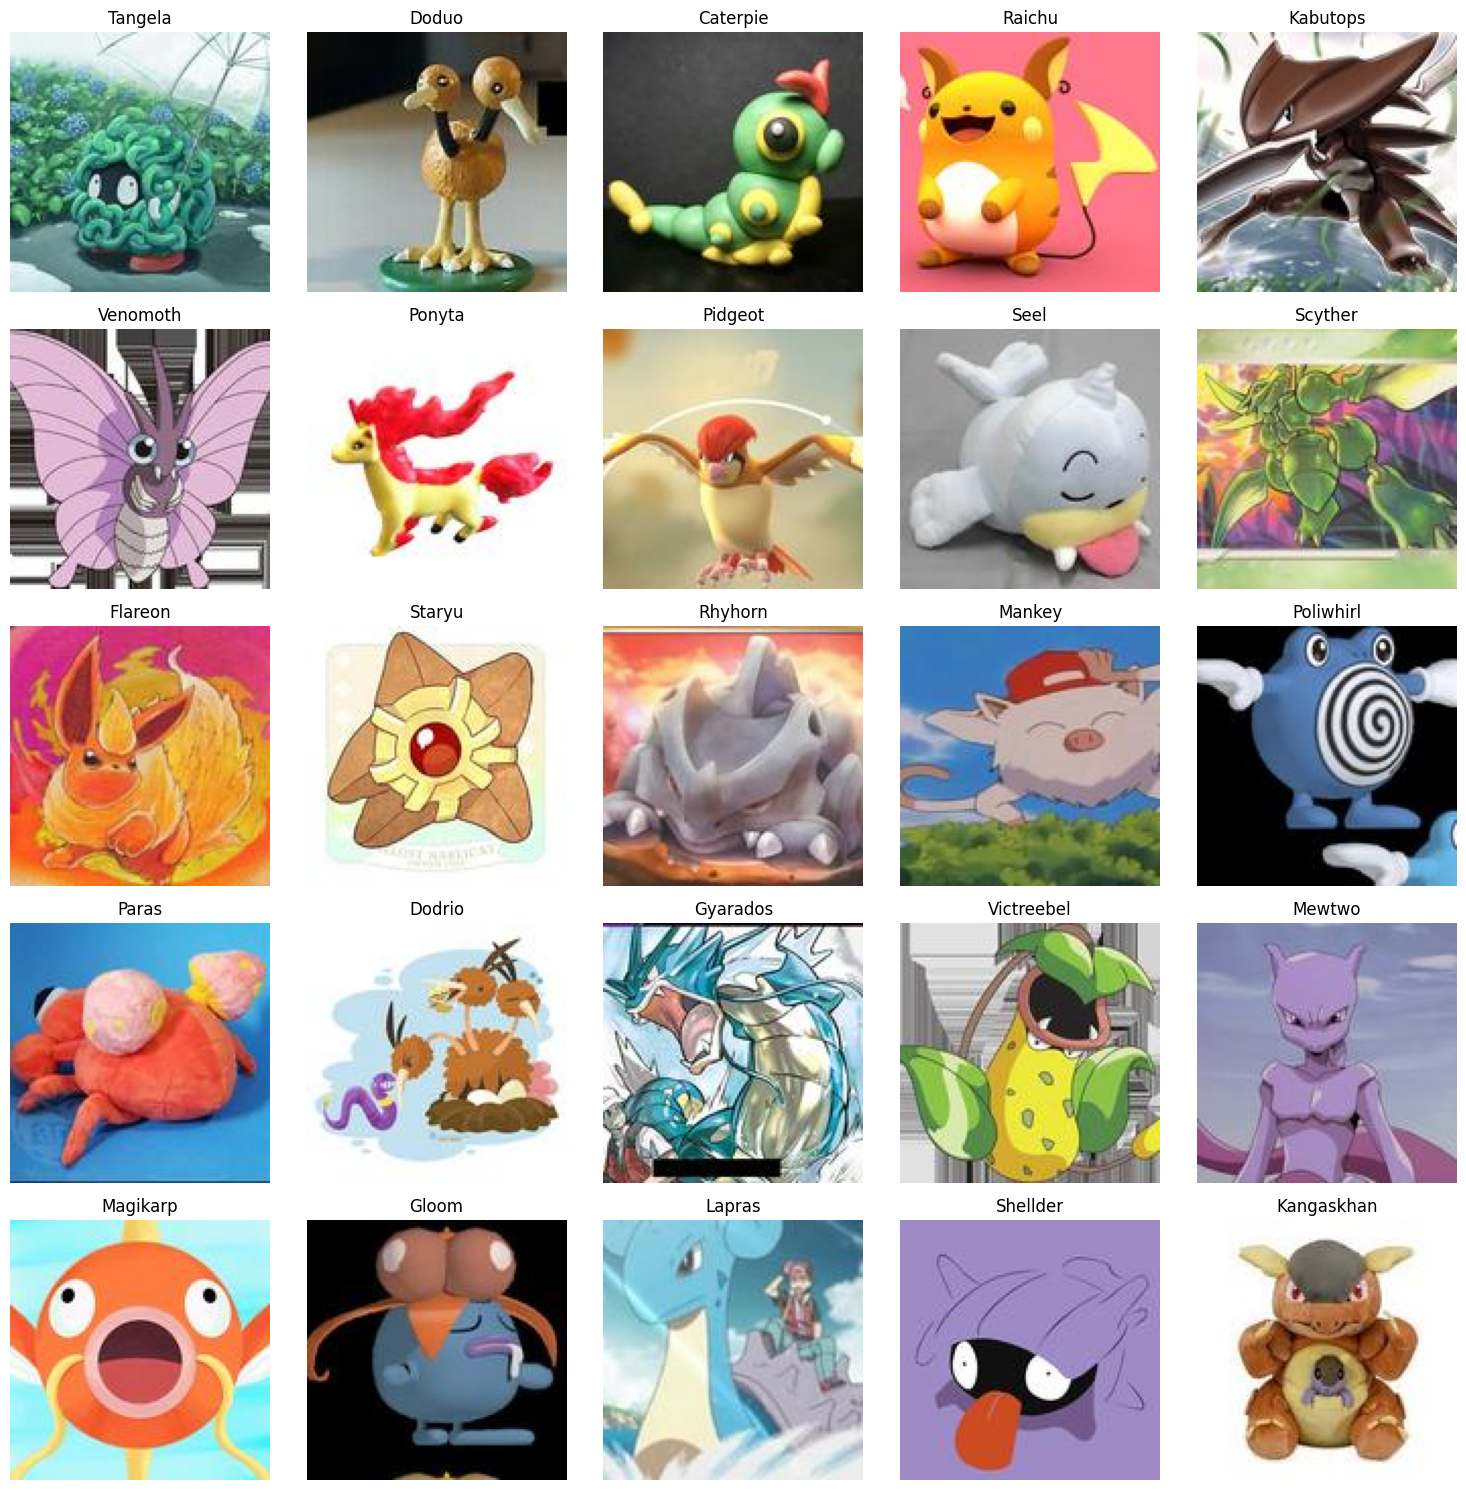

In [5]:
classes = os.listdir(train_dir)

random_classes = random.sample(classes, 25)

num_images_per_class = 1

num_cols = 5
num_rows = (len(random_classes) + num_cols - 1) // num_cols  # Ceiling division

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))

for i, class_name in enumerate(random_classes):
    row = i // num_cols
    col = i % num_cols
    
    class_dir = os.path.join(train_dir, class_name)
    
    image_files = os.listdir(class_dir)
    
    random_image_file = random.choice(image_files)
    
    image_path = os.path.join(class_dir, random_image_file)
    img = imread(image_path)
    
    axes[row, col].imshow(img)
    axes[row, col].set_title(class_name)
    axes[row, col].axis('off')

for i in range(len(random_classes), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Entrenamiento del Modelo

In [31]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers[:-4]:
    layer.trainable = False

In [32]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(151, activation='softmax')(x)

In [33]:
model = Model(inputs=base_model.input, outputs=predictions)

In [34]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
260/260 [==============================] - 22s 80ms/step - loss: 5.7252 - accuracy: 0.0117 - val_loss: 5.5600 - val_accuracy: 0.0151 - lr: 0.0010
Epoch 2/100
260/260 [==============================] - 20s 76ms/step - loss: 5.1970 - accuracy: 0.0245 - val_loss: 5.6898 - val_accuracy: 0.0221 - lr: 0.0010
Epoch 3/100
260/260 [==============================] - 20s 78ms/step - loss: 4.7782 - accuracy: 0.0399 - val_loss: 5.5912 - val_accuracy: 0.0396 - lr: 0.0010
Epoch 4/100
260/260 [==============================] - 20s 77ms/step - loss: 4.5738 - accuracy: 0.0454 - val_loss: 10.5331 - val_accuracy: 0.0204 - lr: 0.0010
Epoch 5/100
260/260 [==============================] - 20s 78ms/step - loss: 4.3803 - accuracy: 0.0514 - val_loss: 4.6797 - val_accuracy: 0.0750 - lr: 0.0010
Epoch 6/100
260/260 [==============================] - 20s 77ms/step - loss: 4.1014 - accuracy: 0.0713 - val_loss: 12.4968 - val_accuracy: 0.0175 - lr: 0.0010
Epoch 7/100
260/260 [=============================

In [37]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

60/60 [==============================] - 1s 19ms/step - loss: 1.1546 - accuracy: 0.7635


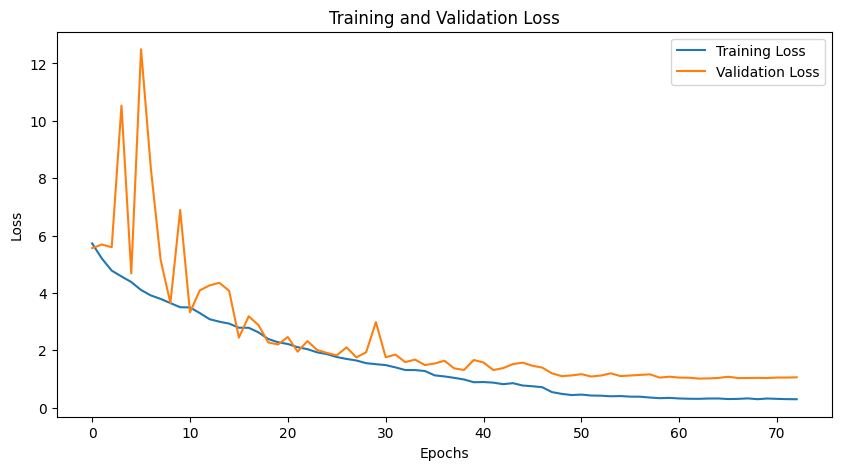

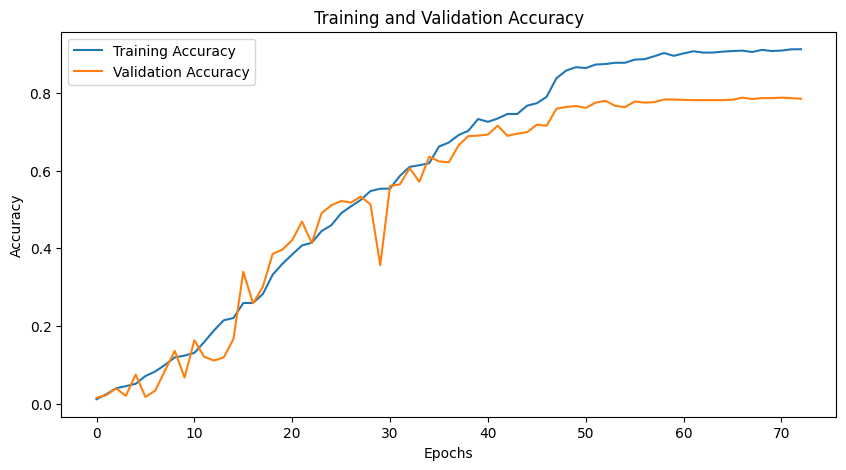

In [38]:
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']

validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluación

In [39]:
evaluation = model.evaluate(validation_generator)
print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])

54/54 [==============================] - 1s 19ms/step - loss: 1.0129 - accuracy: 0.7813
Validation Loss: 1.0129424333572388
Validation Accuracy: 0.7812681794166565


## Conclusión

A pesar de que se intentó utilizar una red neuronal compleja con múltiples capas densas e incluso ajustar el learning rate con regularizadores y dropout no se logró aumentar el val accuracy más allá de 0.78, incluso utilizando transfer learning, sin embargo, para la gran cantidad de categorías que debe clasificar y el parecido que tienen muchos Pokemon entre sí, son resultados que se consideran bastante aceptables.